## This notebook demonstrates how to get importance scores for use with TF-MoDISco using DeepLIFT

It relies on the TAL-GATA example model in the DeepLIFT repository

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
!./grab_model_and_data.sh

File sequences.simdata.gz exists already
File keras2_conv1d_record_5_model_PQzyq_modelJson.json exists already
File keras2_record_5_model_PQzyq_modelWeights.h5 exists already
File test.txt.gz exists already


In [3]:
import gzip
import numpy as np

#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels)
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip("\n") for x in test_ids_fh])

fasta_sequences = []
labels = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split("\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta)
        labels.append([int(task1), int(task2), int(task3)])

labels = np.array(labels)
onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                        for seq in fasta_sequences])
print(labels.shape)
print(onehot_data.shape)

(800, 3)
(800, 200, 4)


### Load the keras model

In [4]:
import deeplift
from keras.models import model_from_json

#load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


Couldn't import dot_parser, loading of dot files will not be possible.


## Prepare the deeplift models

### Model conversion

Convert the keras models to a deeplift model capable of computing importance scores using DeepLIFT.

In [5]:
import deeplift.conversion.kerasapi_conversion as kc
from collections import OrderedDict

deeplift_model = kc.convert_model_from_saved_files(
        h5_file=keras_model_weights,
        json_file=keras_model_json)

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 1 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 3 the preceding linear layer is 2 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
For layer 7 the preceding linear layer is 6 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
For layer 10 the preceding linear layer is 9 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel


### Sanity checks
To ensure that the conversion happend correctly, ensure that the models give identical predictions

If you are using a functional model, see this issue for how to adapt the code: https://github.com/kundajelab/deeplift/issues/54

In [6]:
#make sure predictions are the same as the original model
from deeplift.util import compile_func
deeplift_prediction_func = compile_func([deeplift_model.get_layers()[0].get_activation_vars()],
                                         deeplift_model.get_layers()[-1].get_activation_vars())
original_model_predictions = keras_model.predict(onehot_data, batch_size=200)
converted_model_predictions = deeplift.util.run_function_in_batches(
                                input_data_list=[onehot_data],
                                func=deeplift_prediction_func,
                                batch_size=200,
                                progress_update=None)
print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)))
assert np.max(np.array(converted_model_predictions)-np.array(original_model_predictions)) < 10**-5
predictions = converted_model_predictions

maximum difference in predictions: 0.0


## Compute importance scores

### Compile the DeepLIFT contribution scoring function
Using the deeplift model, we obtain the functions capable of computing the importance scores.

In [7]:
from deeplift.util import get_shuffle_seq_ref_function
from deeplift.dinuc_shuffle import dinuc_shuffle #function to do a dinucleotide shuffle

contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=0,
                                                        target_layer_idx=-2)

### Adapt the scoring function to work with multiple shuffled references

For each sequence, we generate a collection of reference sequences by shuffling the original sequence, and then average the scores over these multiple shuffled versions of the sequence.

In [8]:
contribs_many_refs_func = get_shuffle_seq_ref_function(
    #score_computation_function is the original function to compute scores
    score_computation_function=contribs_func,
    #shuffle_func is the function that shuffles the sequence
    #On real genomic data, a dinuc shuffle is advisable due to
    #the strong bias against CG dinucleotides
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq)
                                     for seq in x]))

### Compile the "hypothetical" contribution scoring function

Hypothetical contribution scores are estimates of the contributions that different bases *would* have if it were present in the sequence. They are found by looking at the DeepLIFT mutlipliers (which satisfy the equation `difference_from_reference*multiplier = contribution`) and substituting in what the different values for `difference_from_reference` would be if other bases were present in the sequence. The hypothetical contributions can act as "autocompletes" of the motifs by revealing the preference of the network for bases that are not present in the sequence. For a longer discussion, see https://github.com/kundajelab/tfmodisco/issues/5

In [9]:
from deeplift.util import get_hypothetical_contribs_func_onehot

multipliers_func = deeplift_model.get_target_multipliers_func(find_scores_layer_idx=0,
                                                              target_layer_idx=-2)
hypothetical_contribs_func = get_hypothetical_contribs_func_onehot(multipliers_func)

#Once again, we rely on multiple shuffled references
hypothetical_contribs_many_refs_func = get_shuffle_seq_ref_function(
    score_computation_function=hypothetical_contribs_func,
    shuffle_func=dinuc_shuffle,
    one_hot_func=lambda x: np.array([one_hot_encode_along_channel_axis(seq)
                                     for seq in x]))


### Obtain the scores

In [10]:
num_refs_per_seq = 10
task_to_contrib_scores = {}
task_to_hyp_contrib_scores = {}
all_tasks = [0,1,2]
for task_idx in all_tasks:
    print("On task",task_idx)
    task_to_contrib_scores[task_idx] =\
        np.sum(contribs_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=fasta_sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=50,
            progress_update=4000,
        ),axis=2)[:,:,None]*onehot_data
    task_to_hyp_contrib_scores[task_idx] =\
        hypothetical_contribs_many_refs_func(
            task_idx=task_idx,
            input_data_sequences=fasta_sequences,
            num_refs_per_seq=num_refs_per_seq,
            batch_size=50,
            progress_update=4000,
        )

On task 0
4000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 4000
4000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 4000
On task 1
4000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 4000
4000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 4000
On task 2
4000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 4000
4000 reference seqs generated
8000 reference seqs generated
One hot encoding sequences...
One hot encoding done...
Done 0
Done 4000


### Sanity check the hypothetical contributions

We make sure that the "hypothetical" contributions of the bases that are actually present in the sequence are the same as the actual contributions of those bases. This should be true by design, so technically you don't have to compute `task_to_contrib_scores[task_idx]` separately in the step above; you can just obtain it using `task_to_contrib_scores[task_idx] = task_to_hyp_contrib_scores[task_idx]*onehot_data`.

In [11]:
for task_idx in all_tasks:
    max_diff = np.max(np.abs(task_to_hyp_contrib_scores[0]*onehot_data - task_to_contrib_scores[0]))
    print("task",task_idx,"max diff:",max_diff)
    assert max_diff < 1e-6 #assert the difference is within numerical precision

task 0 max diff: 2.503395080122317e-07
task 1 max diff: 2.503395080122317e-07
task 2 max diff: 2.503395080122317e-07


### Mean-normalize the hypothetical contributions at each base

This is more of a personal preference. I (Av Shrikumar) find the hypothetical contributions easier to digest visually when they sum up to 0 at each position. I suspect the normalization improves TF-MoDISco results, but I haven't rigorously evaluated this.

In [12]:
for task_idx in all_tasks:
    task_to_hyp_contrib_scores[task_idx] =\
        (task_to_hyp_contrib_scores[task_idx]-
         np.mean(task_to_hyp_contrib_scores[task_idx],axis=-1)[:,:,None])

### Visualize the contributions and hypothetical contributions on a few sequences

It's good to do this as another sanity check. The sequences picked here match the sequences visualized in the corresponding DeepLIFT genomics notebook.

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



Scores for task 0, seq idx 731
Actual contributions


Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN 5005)


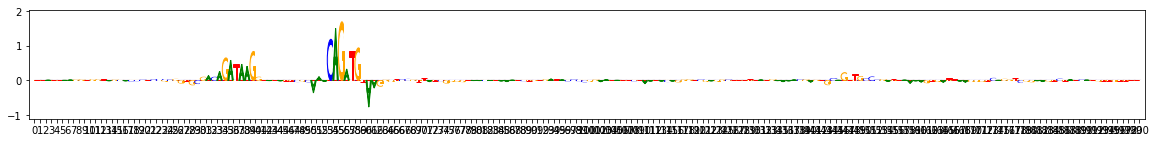

Mean-normalized hypothetical contributions


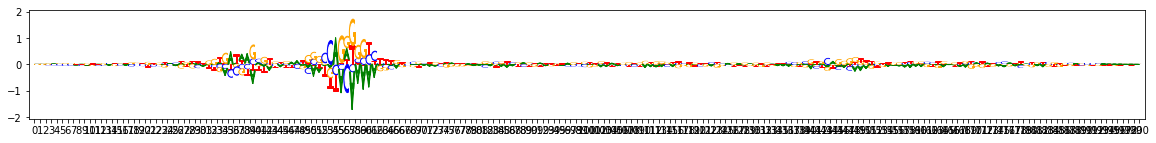

Scores for task 1, seq idx 197
Actual contributions


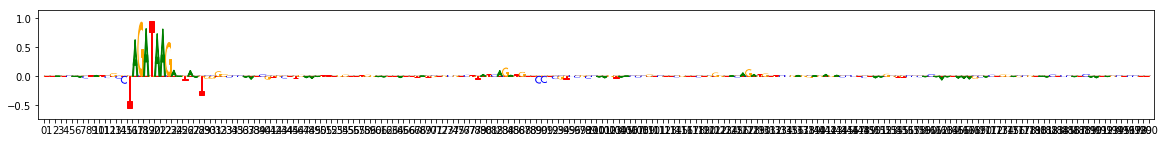

Mean-normalized hypothetical contributions


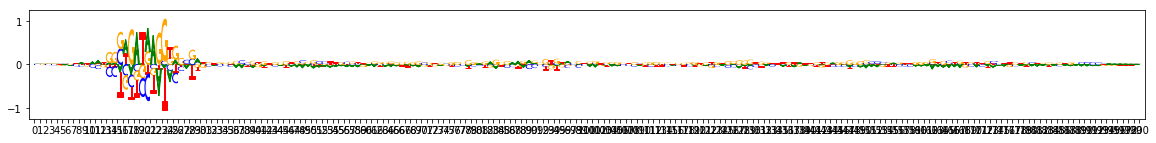

In [13]:
from modisco.visualization import viz_sequence

print("Scores for task 0, seq idx 731")
print("Actual contributions")
viz_sequence.plot_weights(task_to_contrib_scores[0][731])
print("Mean-normalized hypothetical contributions")
viz_sequence.plot_weights(task_to_hyp_contrib_scores[0][731])

print("Scores for task 1, seq idx 197")
print("Actual contributions")
viz_sequence.plot_weights(task_to_contrib_scores[1][197])
print("Mean-normalized hypothetical contributions")
viz_sequence.plot_weights(task_to_hyp_contrib_scores[1][197])

## Save the importance scores

In [14]:
import h5py
import os

if (os.path.isfile("scores.h5")):
    !rm scores.h5
f = h5py.File("scores.h5")
g = f.create_group("contrib_scores")
for task_idx in all_tasks:
    g.create_dataset("task"+str(task_idx), data=task_to_contrib_scores[task_idx])
g = f.create_group("hyp_contrib_scores")
for task_idx in all_tasks:
    g.create_dataset("task"+str(task_idx), data=task_to_hyp_contrib_scores[task_idx])
f.close()